# Metrics

In [1]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

os.chdir('../')

from tgmm import GaussianMixture, ClusteringMetrics, dynamic_figsize, plot_gmm, match_true_labels

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

CUDA version: 12.4
Device: NVIDIA GeForce RTX 4060 Laptop GPU


---
## Synthetic Data Generation

The synthetic dataset is generated by combining four Gaussian components:

- **Component 1:** Centered at `[0, 2]` with spherical covariance.
- **Component 2:** Centered at `[2, -2]` with spherical covariance (fewer points).
- **Component 3:** Centered at `[0, 0]` with diagonal covariance.
- **Component 4:** Centered at `[2, 2]` with full covariance.

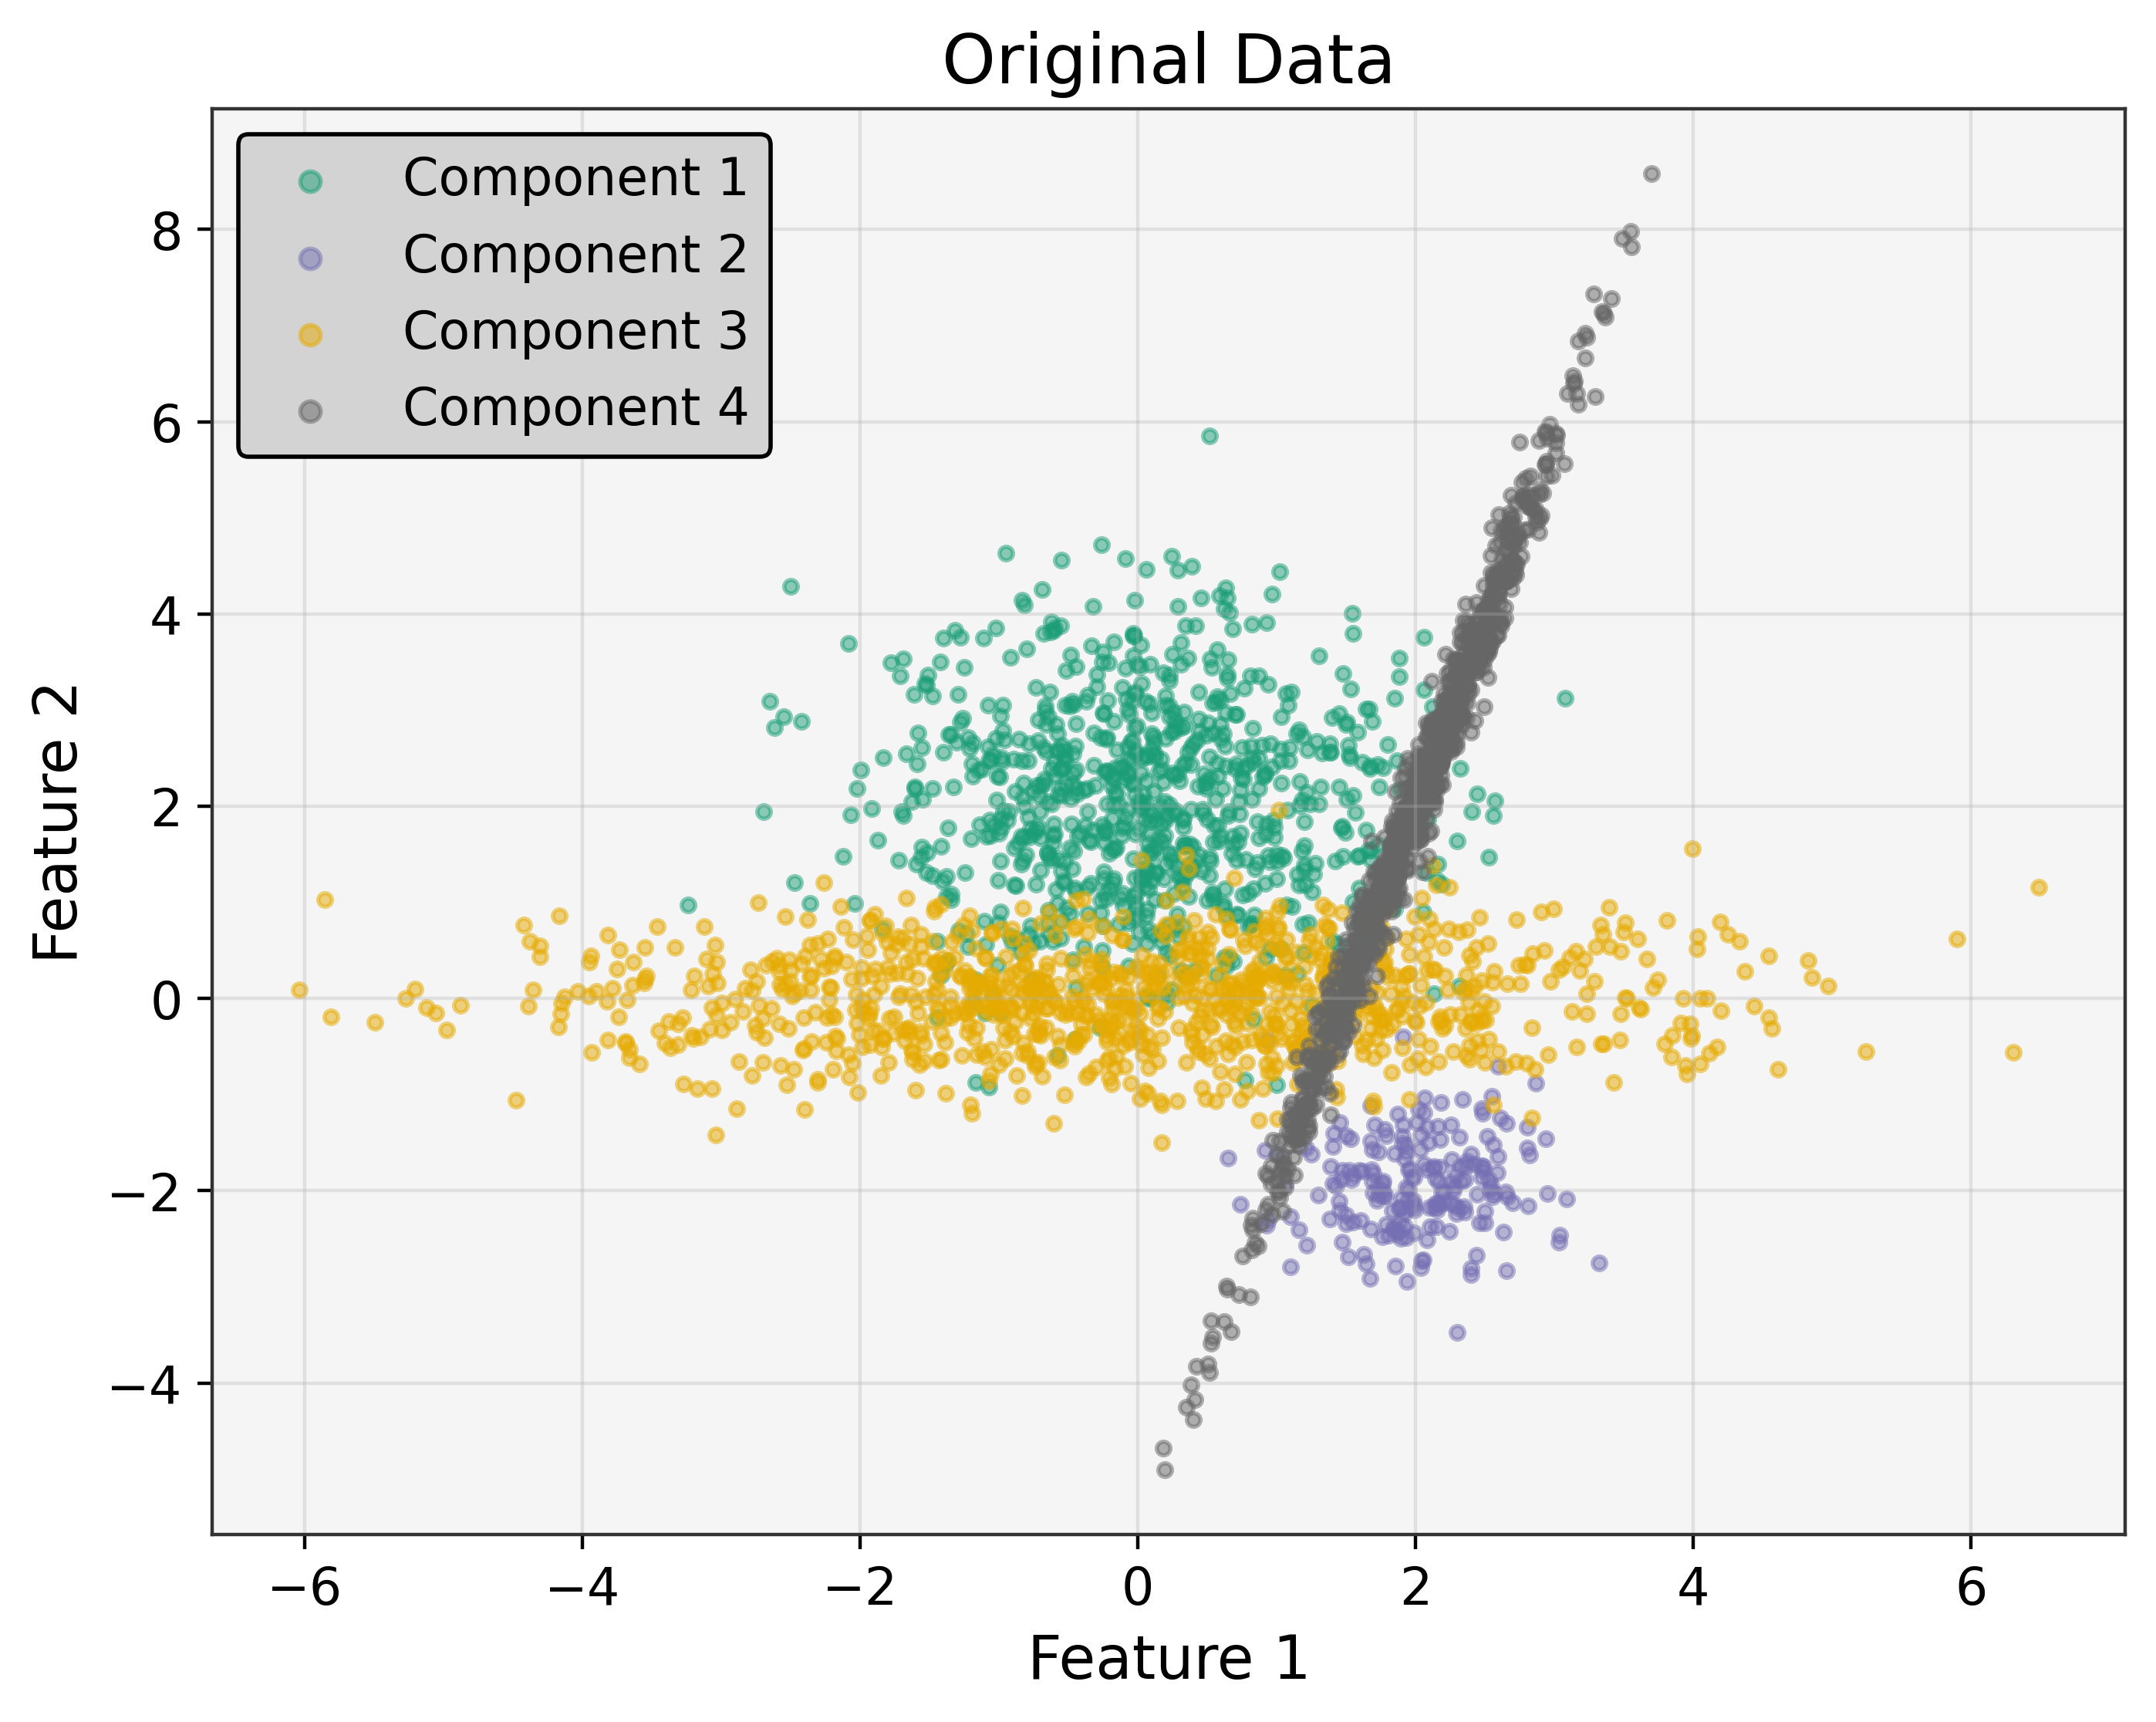

In [2]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(labels, dtype=torch.long, device=device)

n_features = X.shape[1]
n_components = len(n_samples)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

---

## Unsupervised Clustering Metrics Definitions

Below are the definitions of the unsupervised clustering metrics used in this thesis.



### Silhouette Score

The **Silhouette Score** quantifies how similar each data point is to its own cluster compared to other clusters. For a data point $ \mathbf{x}_i $ belonging to cluster $ C_k $, the silhouette value is defined as

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}},
$$

where:
- $ a(i) $ is the average distance between $\mathbf{x}_i$ and all other points in the same cluster $ C_k $ (i.e., the intra-cluster distance),
- $ b(i) $ is the smallest average distance between $\mathbf{x}_i$ and all points in any other cluster (i.e., the nearest-cluster distance).

A high silhouette score (close to 1) indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters.



### Davies-Bouldin Index

The **Davies-Bouldin Index (DB)** measures the average similarity between each cluster and its most similar one. It is defined as

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{S_i + S_j}{M_{ij}},
$$

where:
- $ S_i $ is the average distance between the points in cluster $ i $ and the centroid of $ i $,
- $ M_{ij} $ is the distance between the centroids of clusters $ i $ and $ j $.

Lower values of the Davies-Bouldin Index indicate better clustering quality, as they reflect smaller within-cluster dispersion relative to the separation between clusters.



### Calinski-Harabasz Score

The **Calinski-Harabasz Score (CH)** (also known as the Variance Ratio Criterion) is given by

$$
\text{CH} = \frac{n-k}{k-1}\cdot\frac{\sum _{i=1}^{k}n_{i}||\mathbf {c} _{i}-\mathbf {c} ||^{2}}{\sum _{i=1}^{k}\sum _{\mathbf {x} \in C_{i}}||\mathbf {x} -\mathbf {c} _{i}||^{2}},
$$

where:
- $ k $ is the number of clusters,
- $ n $ is the total number of samples.

Higher Calinski-Harabasz scores suggest a model in which clusters are dense and well separated.



### Dunn Index

The **Dunn Index** seeks to identify clusters that are both compact and well separated. It is defined as

$$
D = \frac{\min\limits_{i \neq j} d(C_i, C_j)}{\max\limits_{k} \mathrm{diam}(C_k)},
$$

where:
- $ d(C_i, C_j) $ is the minimum distance between any two points in clusters $ C_i $ and $ C_j $,
- $ \mathrm{diam}(C_k) $ is the maximum distance between any two points in cluster $ C_k $.

A higher Dunn Index indicates better clustering, meaning that the clusters are more compact and well separated.



### Bayesian Information Criterion (BIC)

The **Bayesian Information Criterion (BIC)** is used for model selection by penalizing model complexity while rewarding goodness-of-fit. It is computed as

$$
\text{BIC} = n_{\text{params}} \cdot \ln(N) - 2 \cdot \mathcal{L},
$$

where:
- $ n_{\text{params}} $ is the number of free parameters in the model,
- $ N $ is the number of samples,
- $ \mathcal{L} $ is the log-likelihood of the model.

Lower BIC values indicate a model that better balances fit and simplicity.



### Akaike Information Criterion (AIC)

The **Akaike Information Criterion (AIC)** is another metric for model selection defined as

$$
\text{AIC} = 2 \cdot n_{\text{params}} - 2 \cdot \mathcal{L}.
$$

As with BIC, lower AIC values suggest a model that achieves a good trade-off between complexity and fit quality.



**Note:** In practice, the ideal number of clusters is typically determined by seeking a maximum in the Silhouette Score, Calinski-Harabasz Score, and Dunn Index, while simultaneously looking for minima in the Davies-Bouldin Index, AIC, and BIC.


Evaluating range:   0%|          | 0/9 [00:00<?, ?it/s]

Evaluating range: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


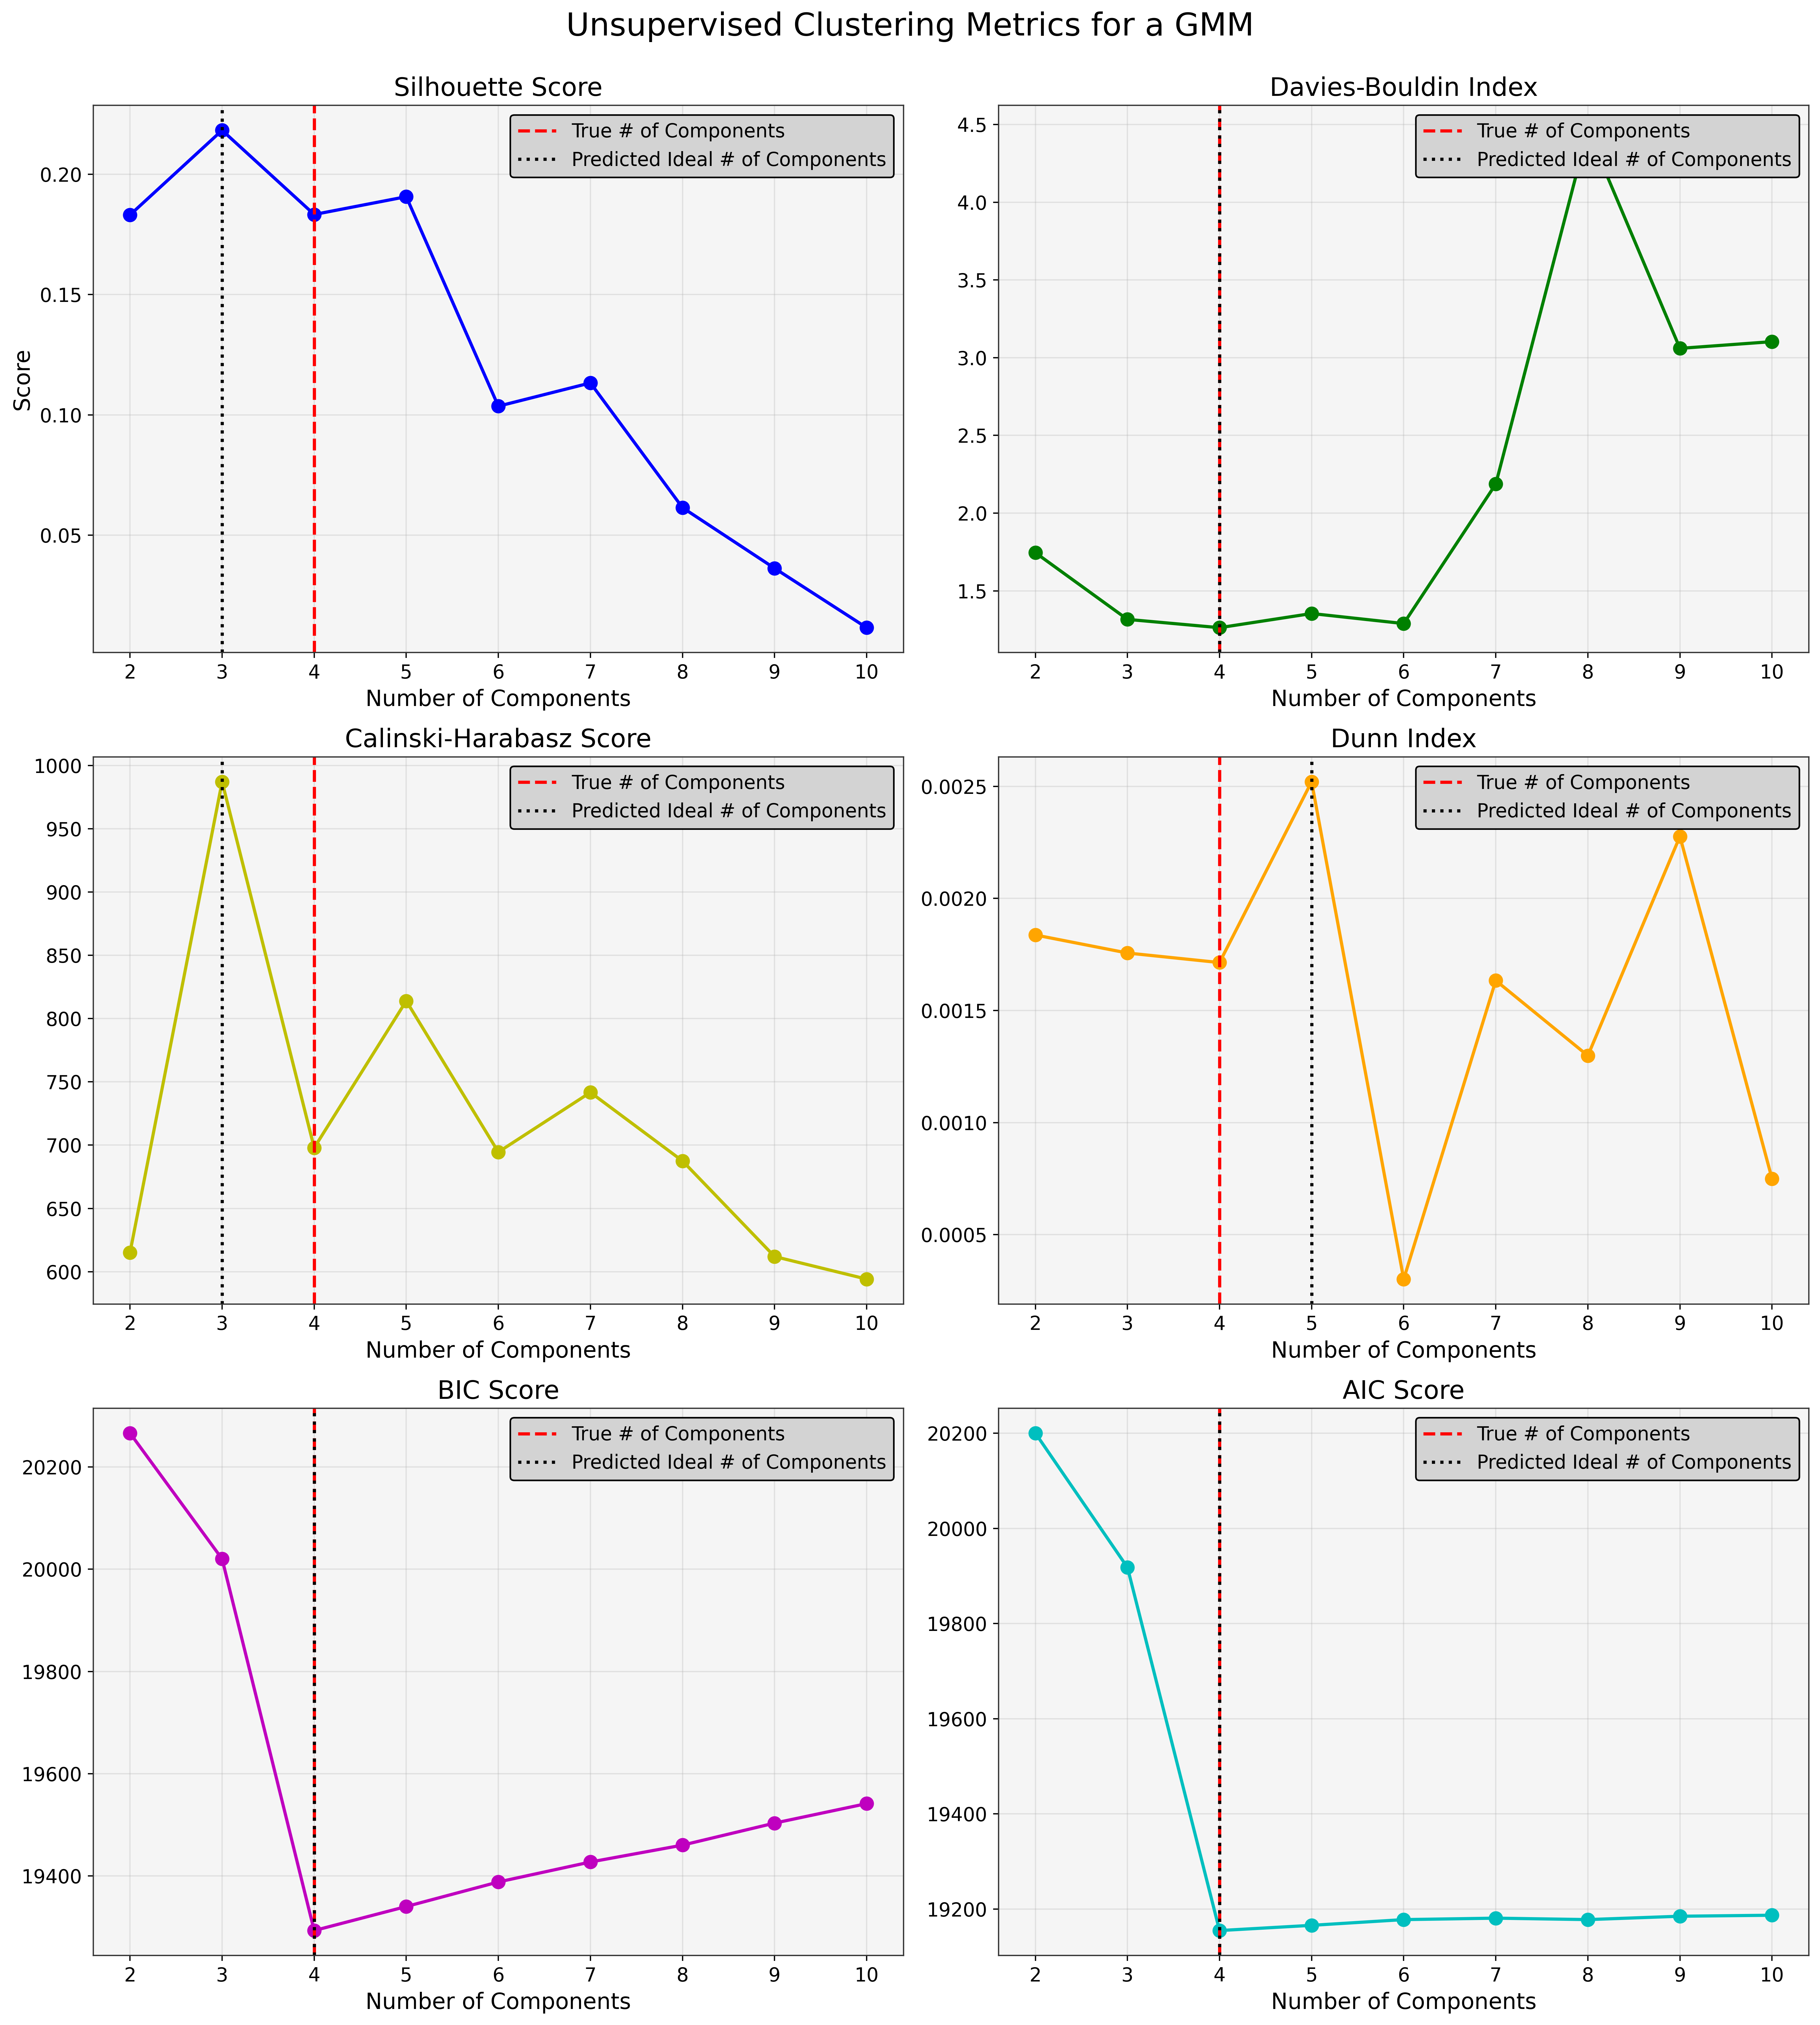

=== Best Number of Components According to Each Metric ===
Silhouette Best: 3
Davies-Bouldin Best (lowest): 4
Calinski-Harabasz Best: 3
Dunn Index Best: 5
BIC Best (lowest): 4
AIC Best (lowest): 4


In [3]:
components_range = np.arange(2, 11)
silhouette_vals = torch.zeros(len(components_range), device=device)
davies_vals = torch.zeros(len(components_range), device=device)
calinski_vals = torch.zeros(len(components_range), device=device)
dunn_vals = torch.zeros(len(components_range), device=device)
bic_vals = torch.zeros(len(components_range), device=device)
aic_vals = torch.zeros(len(components_range), device=device)

# Fit a GMM for each n in components_range
for i, n in tqdm(enumerate(components_range), total=len(components_range), desc="Evaluating range"):
    gmm = GaussianMixture(
        n_features=n_features,
        n_components=n,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device,
        random_state=random_state,
        tol=1e-5,
        reg_covar=1e-7
    )
    # Fit
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor)  # shape (N,)

    # Compute unsupervised metrics
    silhouette_vals[i] = ClusteringMetrics.silhouette_score(X_tensor, labels_pred, n_components=n)
    davies_vals[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, labels_pred, n_components=n)
    calinski_vals[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, labels_pred, n_components=n)
    dunn_vals[i] = ClusteringMetrics.dunn_index(X_tensor, labels_pred, n_components=n)
    bic_vals[i] = ClusteringMetrics.bic_score(gmm.score(X_tensor), X_tensor, n, gmm.covariance_type)
    aic_vals[i] = ClusteringMetrics.aic_score(gmm.score(X_tensor), X_tensor, n, gmm.covariance_type)

# Compute the predicted ideal number of components for each metric
sil_best = components_range[torch.argmax(silhouette_vals)].item()
davies_best = components_range[torch.argmin(davies_vals)].item()
calinski_best = components_range[torch.argmax(calinski_vals)].item()
dunn_best = components_range[torch.argmax(dunn_vals)].item()
bic_best = components_range[torch.argmin(bic_vals)].item()
aic_best = components_range[torch.argmin(aic_vals)].item()

# Create a 3-rows x 2-columns figure (3 rows, 2 columns)
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=dynamic_figsize(nrows, ncols))

# 1) Silhouette Score (Row 1, Col 1)
axs[0, 0].plot(components_range, silhouette_vals.cpu(), 'o-b')
axs[0, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[0, 0].axvline(x=sil_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].set_xlabel('Number of Components')
axs[0, 0].set_ylabel('Score')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper right')

# 2) Davies-Bouldin Index (Row 1, Col 2)
axs[0, 1].plot(components_range, davies_vals.cpu(), 'o-g')
axs[0, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[0, 1].axvline(x=davies_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[0, 1].set_title('Davies-Bouldin Index')
axs[0, 1].set_xlabel('Number of Components')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper right')

# 3) Calinski-Harabasz Score (Row 2, Col 1)
axs[1, 0].plot(components_range, calinski_vals.cpu(), 'o-y')
axs[1, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[1, 0].axvline(x=calinski_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[1, 0].set_title('Calinski-Harabasz Score')
axs[1, 0].set_xlabel('Number of Components')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper right')

# 4) Dunn Index (Row 2, Col 2)
axs[1, 1].plot(components_range, dunn_vals.cpu(), 'o-', color='orange')
axs[1, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[1, 1].axvline(x=dunn_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[1, 1].set_title('Dunn Index')
axs[1, 1].set_xlabel('Number of Components')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper right')

# 5) BIC Score (Row 3, Col 1)
axs[2, 0].plot(components_range, bic_vals.cpu(), 'o-m')
axs[2, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[2, 0].axvline(x=bic_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[2, 0].set_title('BIC Score')
axs[2, 0].set_xlabel('Number of Components')
axs[2, 0].grid(True)
axs[2, 0].legend(loc='upper right')

# 6) AIC Score (Row 3, Col 2)
axs[2, 1].plot(components_range, aic_vals.cpu(), 'o-c')
axs[2, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[2, 1].axvline(x=aic_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[2, 1].set_title('AIC Score')
axs[2, 1].set_xlabel('Number of Components')
axs[2, 1].grid(True)
axs[2, 1].legend(loc='upper right')

plt.suptitle("Unsupervised Clustering Metrics for a GMM")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print("=== Best Number of Components According to Each Metric ===")
print(f"Silhouette Best: {sil_best}")
print(f"Davies-Bouldin Best (lowest): {davies_best}")
print(f"Calinski-Harabasz Best: {calinski_best}")
print(f"Dunn Index Best: {dunn_best}")
print(f"BIC Best (lowest): {bic_best}")
print(f"AIC Best (lowest): {aic_best}")


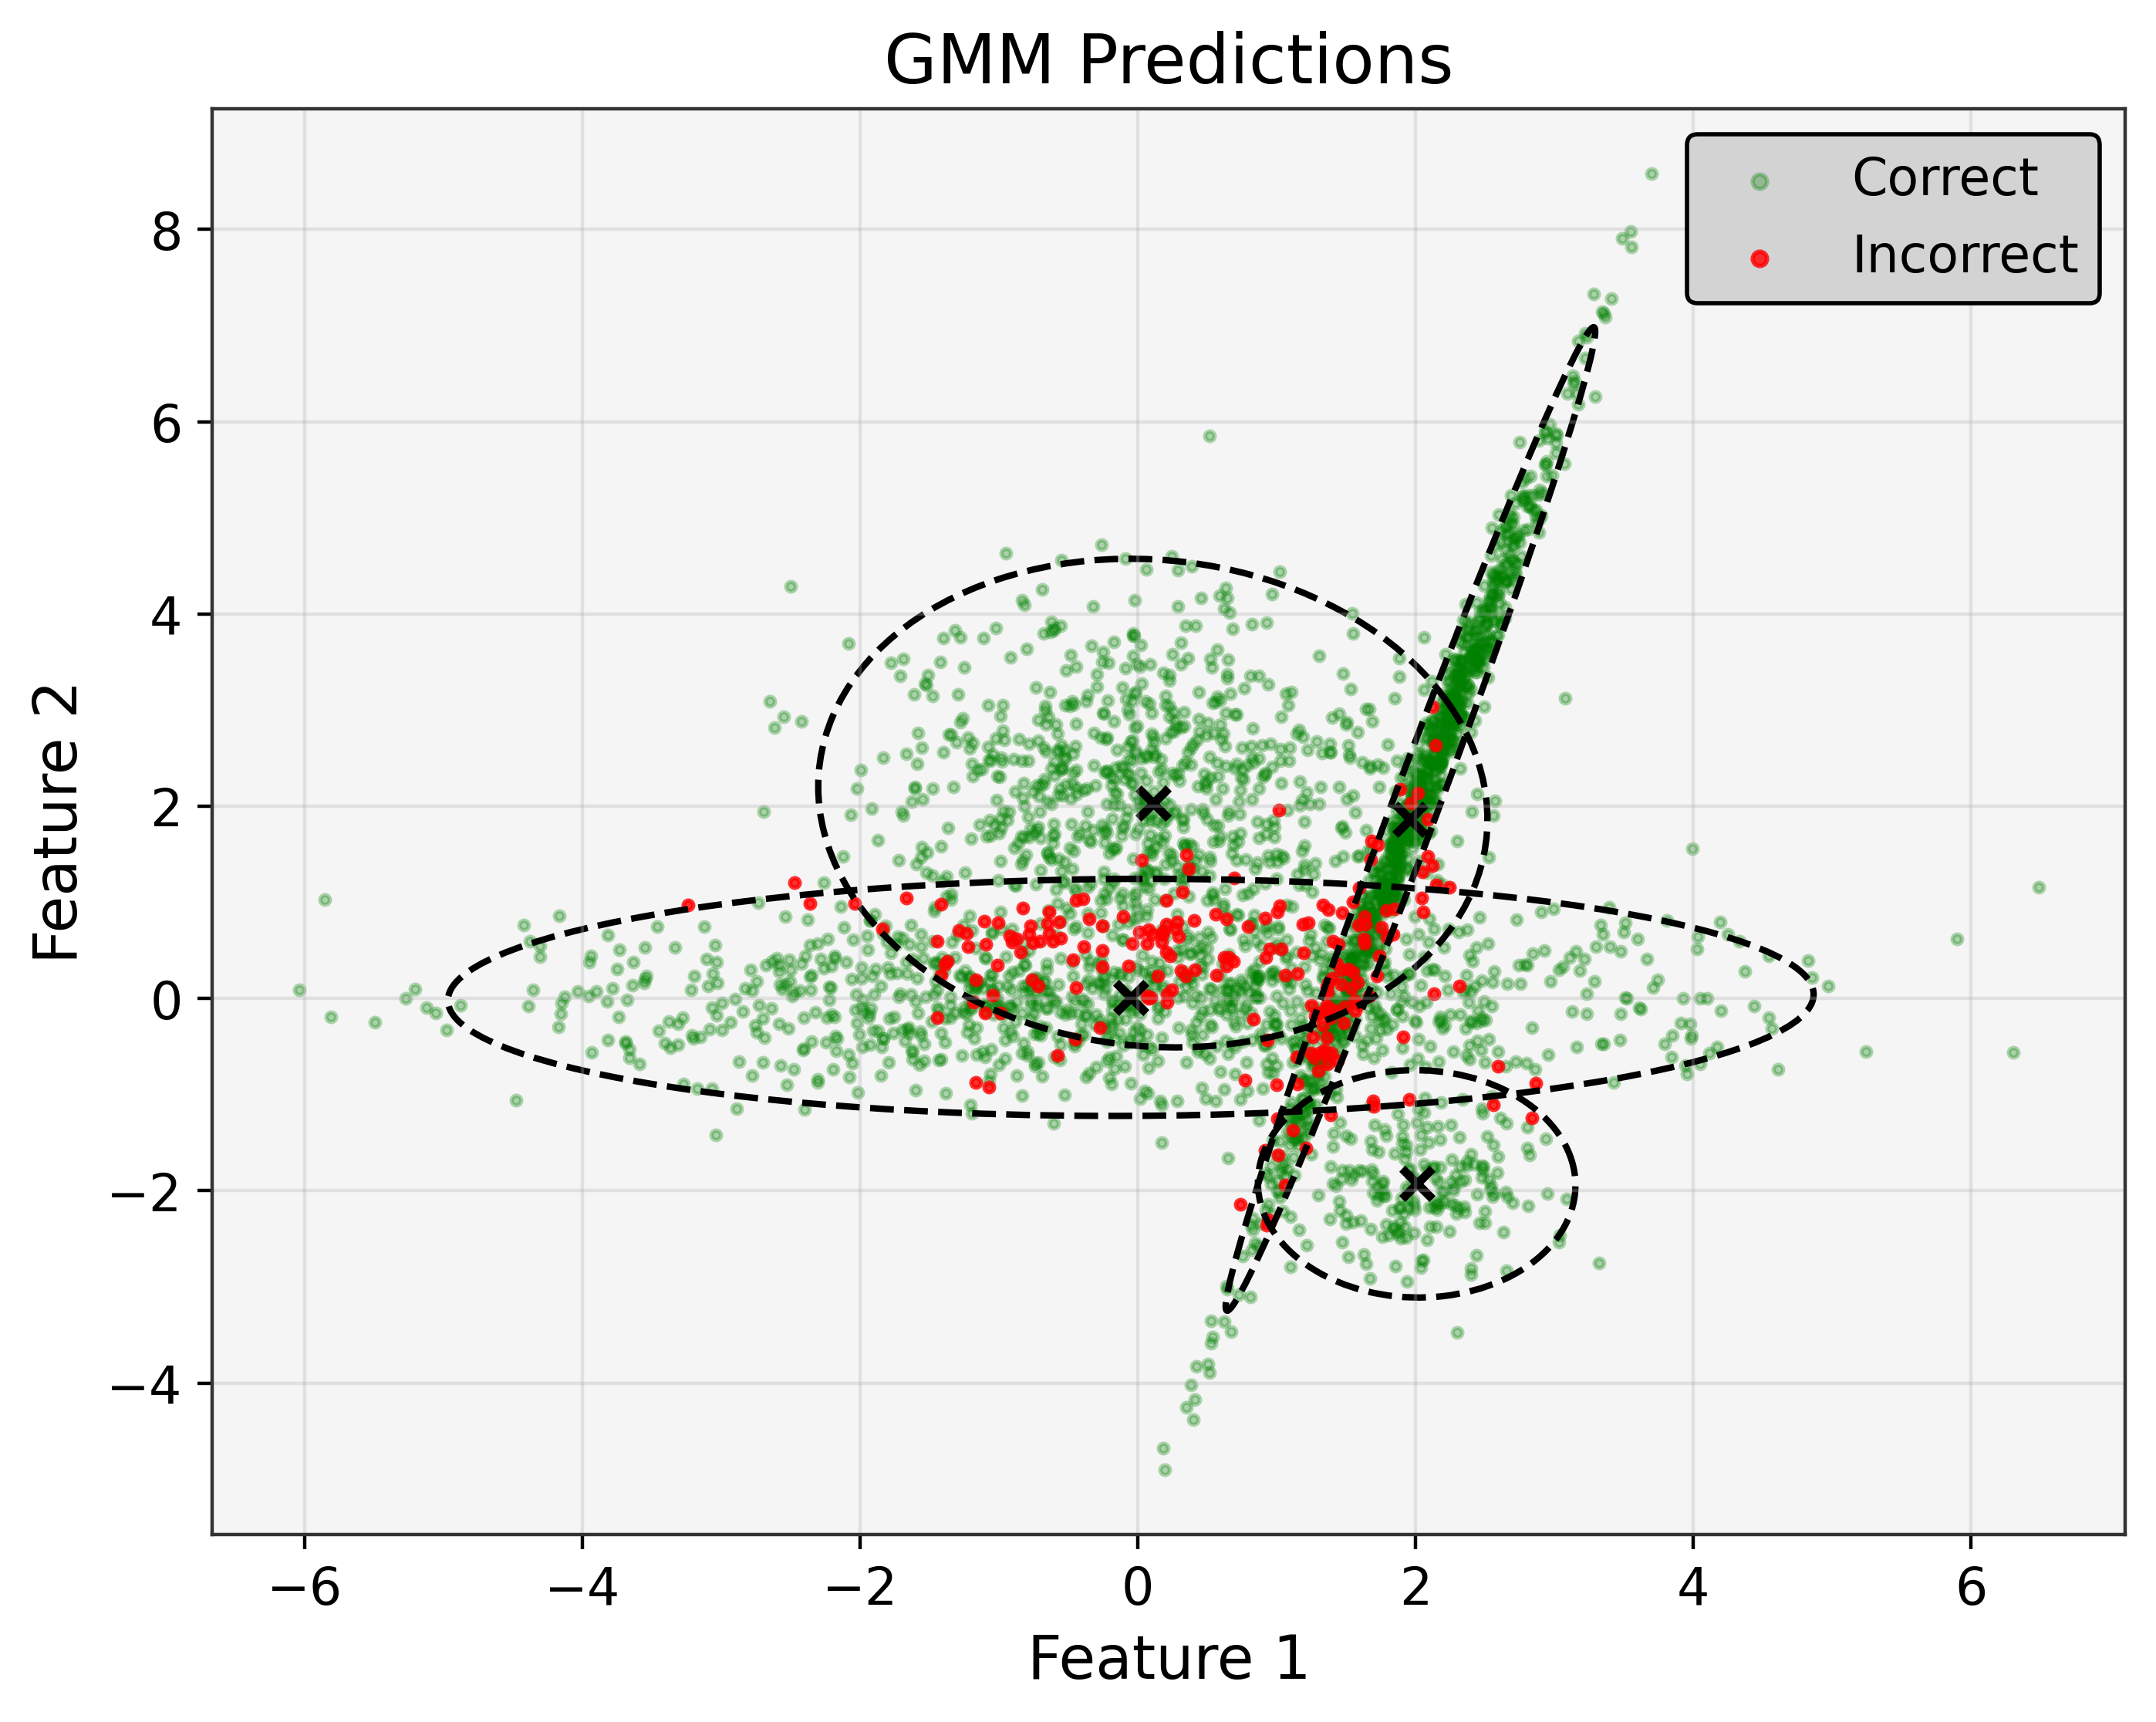

Metric   Torch Score  Sklearn Score  \
0                     rand_score      0.922936       0.922936   
1            adjusted_rand_score      0.816571       0.816571   
2              mutual_info_score      0.980560       0.980560   
3   normalized_mutual_info_score      0.778043       0.778043   
4     adjusted_mutual_info_score      0.777949       0.777777   
5          fowlkes_mallows_score      0.871655       0.871655   
6              homogeneity_score      0.773056       0.774893   
7             completeness_score      0.782989       0.781218   
8                v_measure_score      0.777991       0.778043   
9               silhouette_score      0.184356       0.184356   
10          davies_bouldin_index      1.252130       1.252130   
11       calinski_harabasz_score    701.308289     701.308533   
12                  purity_score      0.931000            NaN   
13                    dunn_index      0.002177            NaN   
14                     bic_score  19292.576172   19292.308851   
15                     aic_score  19154.428955   19154.162397   

    Absolute Difference  Relative Difference (%)  
0          7.921422e-09             8.582850e-07  
1          9.265805e-09             1.134721e-06  
2          2.375290e-08             2.422381e-06  
3          1.091963e-07             1.403475e-05  
4          1.721395e-04             2.213223e-02  
5          3.285231e-08             3.768957e-06  
6          1.837321e-03             2.371064e-01  
7          1.771340e-03             2.267408e-01  
8          5.184373e-05             6.663353e-03  
9          4.470348e-08             2.424840e-05  
10         1.186502e-07             9.475868e-06  
11         2.441406e-04             3.481216e-05  
12                  NaN                      NaN  
13                  NaN                      NaN  
14         2.673210e-01             1.385635e-03  
15         2.665582e-01             1.391646e-03

In [4]:
# Scikit-learn for comparison
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
    homogeneity_score,
    mutual_info_score,
    adjusted_mutual_info_score,
    completeness_score,
    v_measure_score,
    rand_score
)

gmm = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    init_params='kmeans',
    device=device
)
gmm.fit(X_tensor)
labels_pred = gmm.predict(X_tensor)

# Metrics with custom ClusteringMetrics
metrics_to_compare = [
    "rand_score",
    "adjusted_rand_score",
    "mutual_info_score",
    "normalized_mutual_info_score",
    "adjusted_mutual_info_score",
    "fowlkes_mallows_score",
    "homogeneity_score",
    "completeness_score",
    "v_measure_score",
    "silhouette_score",
    "davies_bouldin_index",
    "calinski_harabasz_score",
    "purity_score",   # Torch-only metric
    "dunn_index",     # Torch-only metric
    "bic_score",      # Compare Torch vs Sklearn BIC
    "aic_score",      # Compare Torch vs Sklearn AIC
]
scores_torch = ClusteringMetrics.evaluate_clustering(
    gmm,
    X_tensor,
    true_labels=y_tensor,
    metrics=metrics_to_compare
)

# Compare with sklearn
X_np = X_tensor.cpu().numpy()
y_np = y_tensor.cpu().numpy()
labels_pred_np = labels_pred.cpu().numpy()

sk_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=1000, init_params='kmeans', random_state=random_state, tol=1e-5, reg_covar=1e-7)
sk_gmm.fit(X_np)

scores_sklearn = {
    "rand_score": rand_score(y_np, labels_pred_np),
    "adjusted_rand_score": adjusted_rand_score(y_np, labels_pred_np),
    "mutual_info_score": mutual_info_score(y_np, labels_pred_np),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_np, labels_pred_np),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_np, labels_pred_np),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_np, labels_pred_np),
    "homogeneity_score": homogeneity_score(y_np, labels_pred_np),
    "completeness_score": completeness_score(y_np, labels_pred_np),
    "v_measure_score": v_measure_score(y_np, labels_pred_np),
    "silhouette_score": silhouette_score(X_np, labels_pred_np),
    "davies_bouldin_index": davies_bouldin_score(X_np, labels_pred_np),
    "calinski_harabasz_score": calinski_harabasz_score(X_np, labels_pred_np),
}
sk_bic = sk_gmm.bic(X_np)
sk_aic = sk_gmm.aic(X_np)



rows = []
for metric in metrics_to_compare:
    # Retrieve the Torch metric score if available.
    torch_val = scores_torch.get(metric, None)
    
    # Retrieve the scikit-learn metric score if available.
    if metric in scores_sklearn:
        sklearn_val = scores_sklearn.get(metric)
    elif metric == "bic_score":
        sklearn_val = sk_bic
    elif metric == "aic_score":
        sklearn_val = sk_aic
    else:
        sklearn_val = None
    
    # Calculate the absolute difference and the relative difference in percent.
    if torch_val is not None and sklearn_val is not None:
        abs_diff = abs(torch_val - sklearn_val)
        # Avoid division by zero; if sklearn_val is zero, set relative difference to None.
        rel_diff = (abs_diff / abs(sklearn_val)) * 100 if sklearn_val != 0 else None
    else:
        abs_diff = None
        rel_diff = None
    
    rows.append({
        "Metric": metric,
        "Torch Score": torch_val,
        "Sklearn Score": sklearn_val,
        "Absolute Difference": abs_diff,
        "Relative Difference (%)": rel_diff
    })

fig, ax = plt.subplots(figsize=dynamic_figsize(1, 1))
plot_gmm(X=X_np, gmm=gmm, labels=y_tensor, match_labels=True, ax=ax, mode='outliers', title='GMM Predictions')
plt.show()

df_metrics = pd.DataFrame(rows)
df_metrics


/tmp/ipykernel_19713/2970968731.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_tensor, dtype=torch.long),
/tmp/ipykernel_19713/2970968731.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(matched_pred, dtype=torch.long)


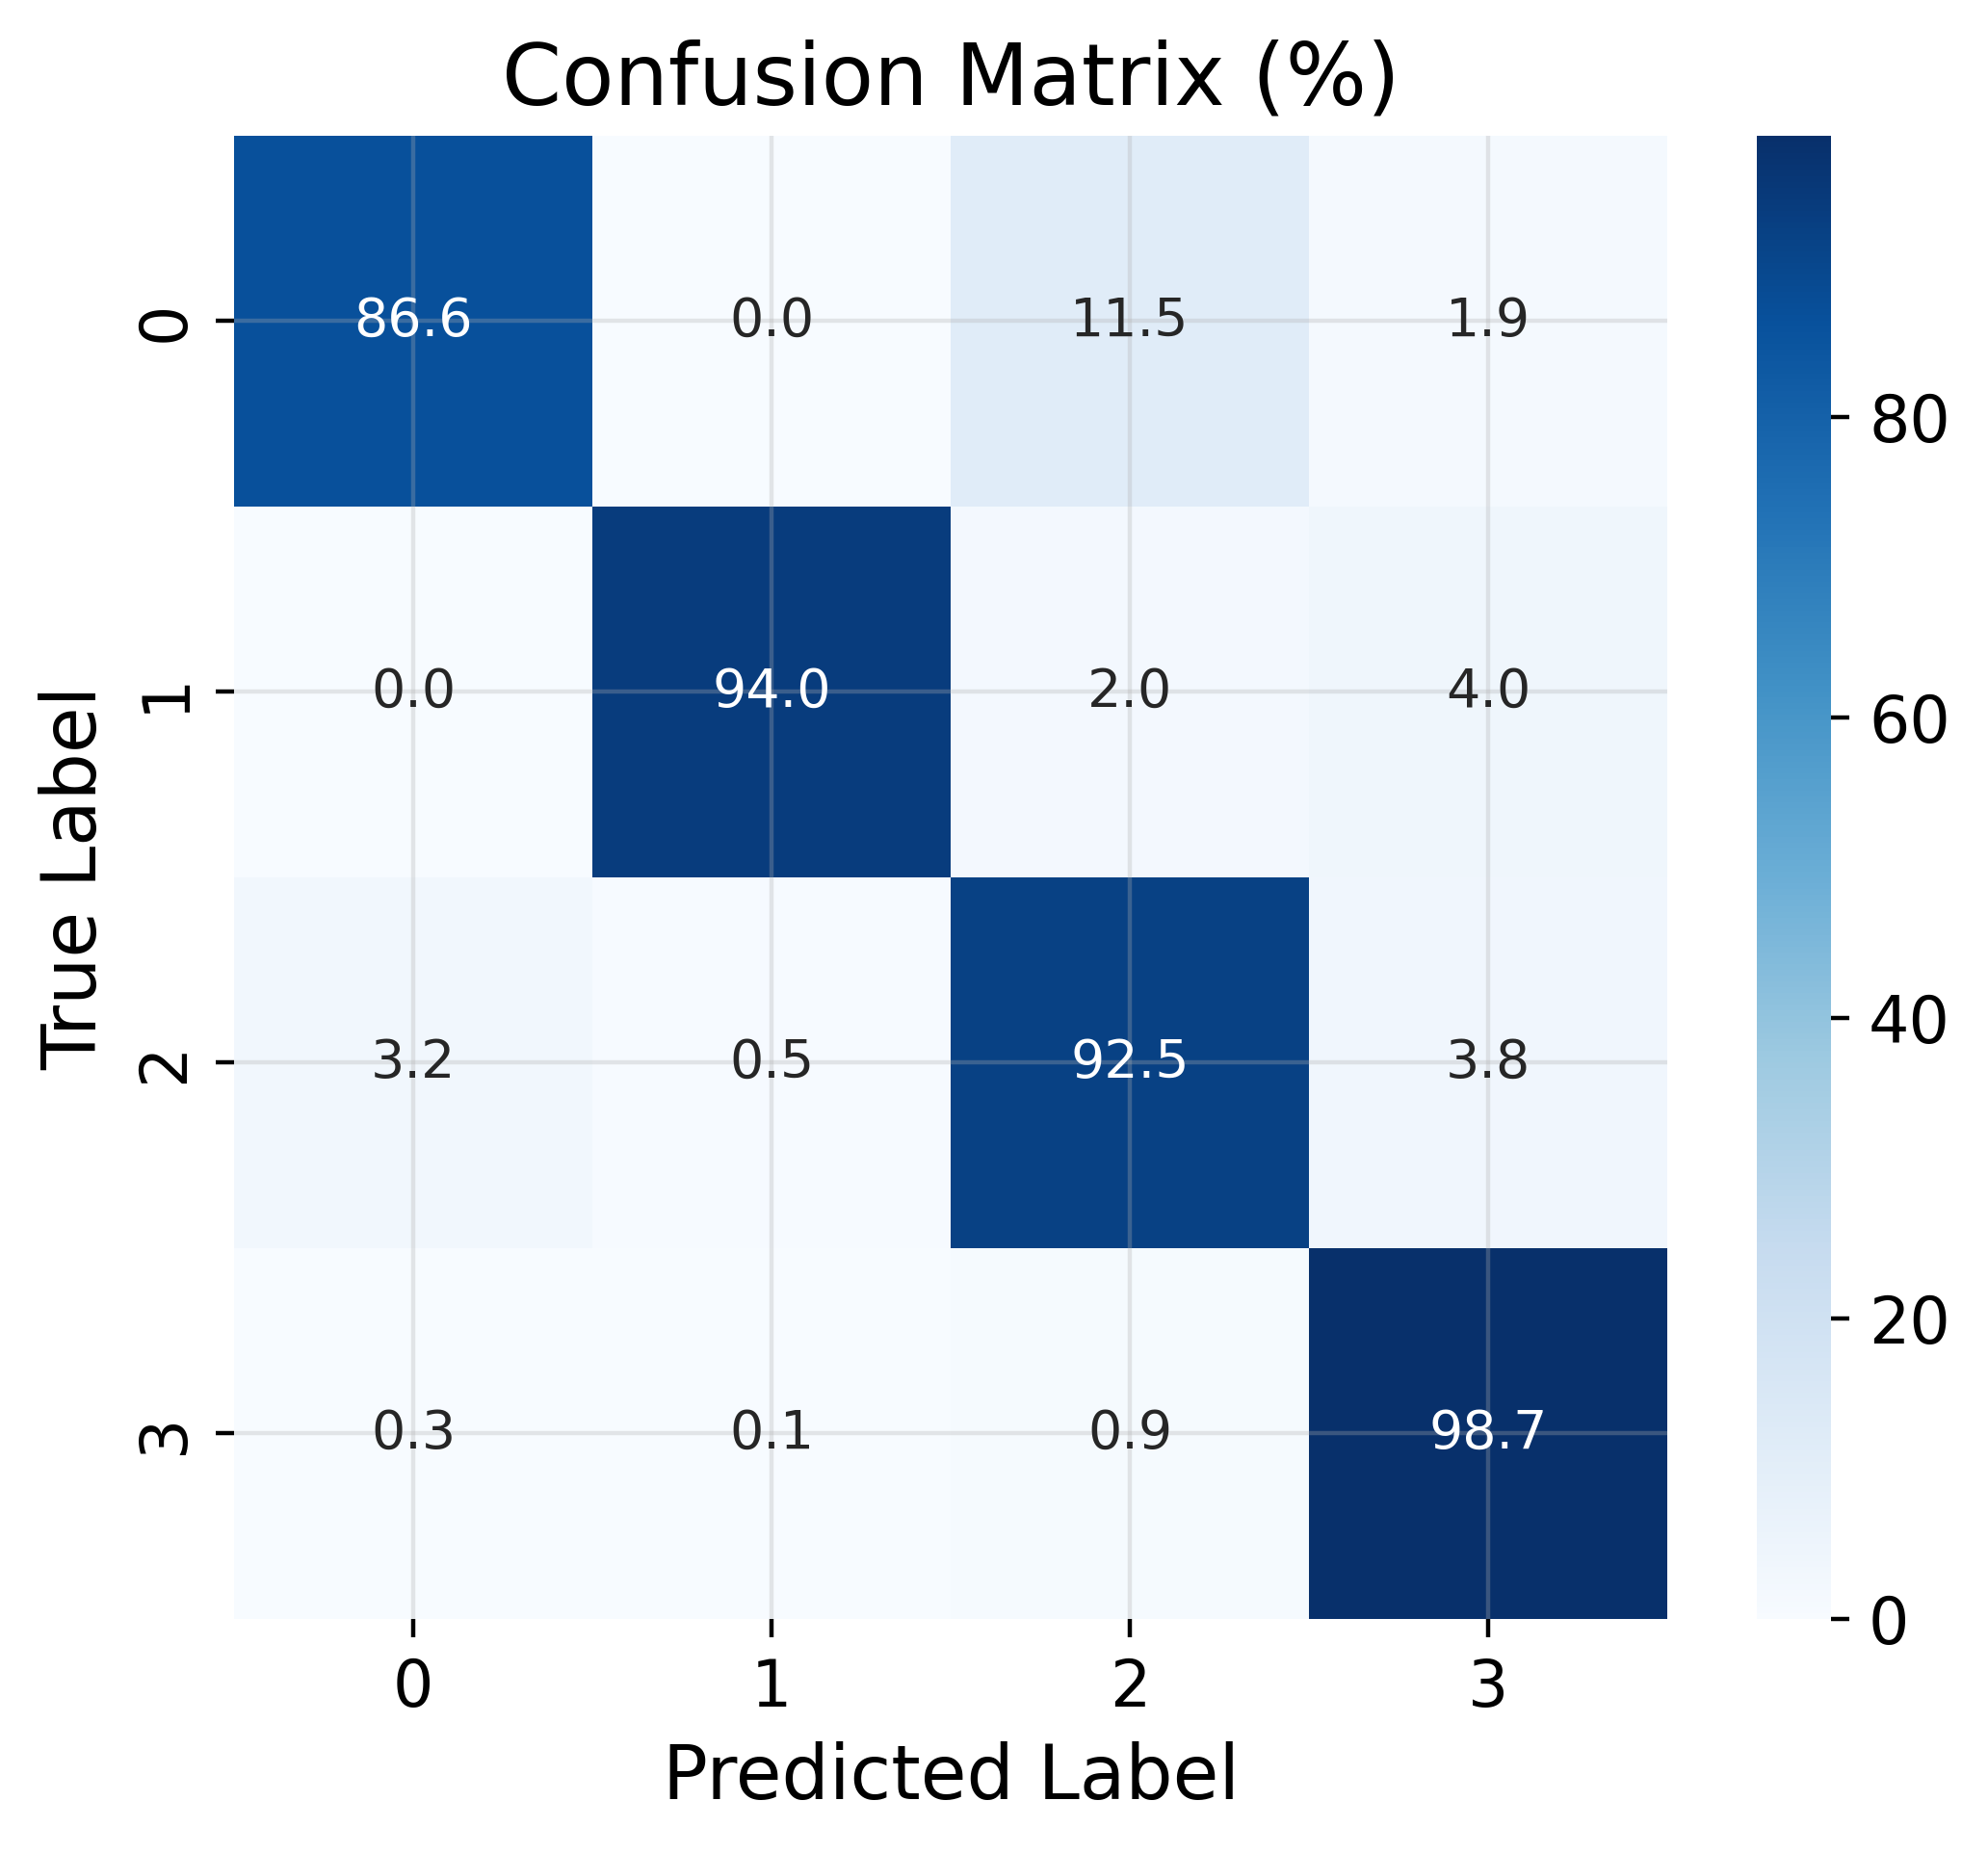

/tmp/ipykernel_19713/2970968731.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_tensor, dtype=torch.long),
/tmp/ipykernel_19713/2970968731.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(matched_pred, dtype=torch.long)


precision   recall  f1-score  support   jaccard   roc_auc
0   0.951923  0.86625  0.907068    800.0  0.829940  0.997872
1   0.969072  0.94000  0.954315    200.0  0.912621  0.982729
2   0.898058  0.92500  0.911330   1000.0  0.837104  0.917763
3   0.941794  0.98700  0.963867   1000.0  0.930254  0.956896

In [5]:
# Get matched predictions
matched_pred = match_true_labels(y_tensor, labels_pred)

# Compute confusion matrix using ClusteringMetrics.confusion_matrix
cm = ClusteringMetrics.confusion_matrix(
    torch.tensor(y_tensor, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)

# Convert the confusion matrix to percentages (normalize per true label)
cm_np = cm.numpy().astype(float)
cm_percent = (cm_np.T / cm_np.sum(axis=1)).T * 100

# Plot heatmap of the percent confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues")
plt.title("Confusion Matrix (%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate classification report
report = ClusteringMetrics.classification_report(
    torch.tensor(y_tensor, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)

# Convert classification report to a DataFrame for display
report_df = pd.DataFrame(report).T
report_df

Computing KL(p||q) for different numbers of components...


100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


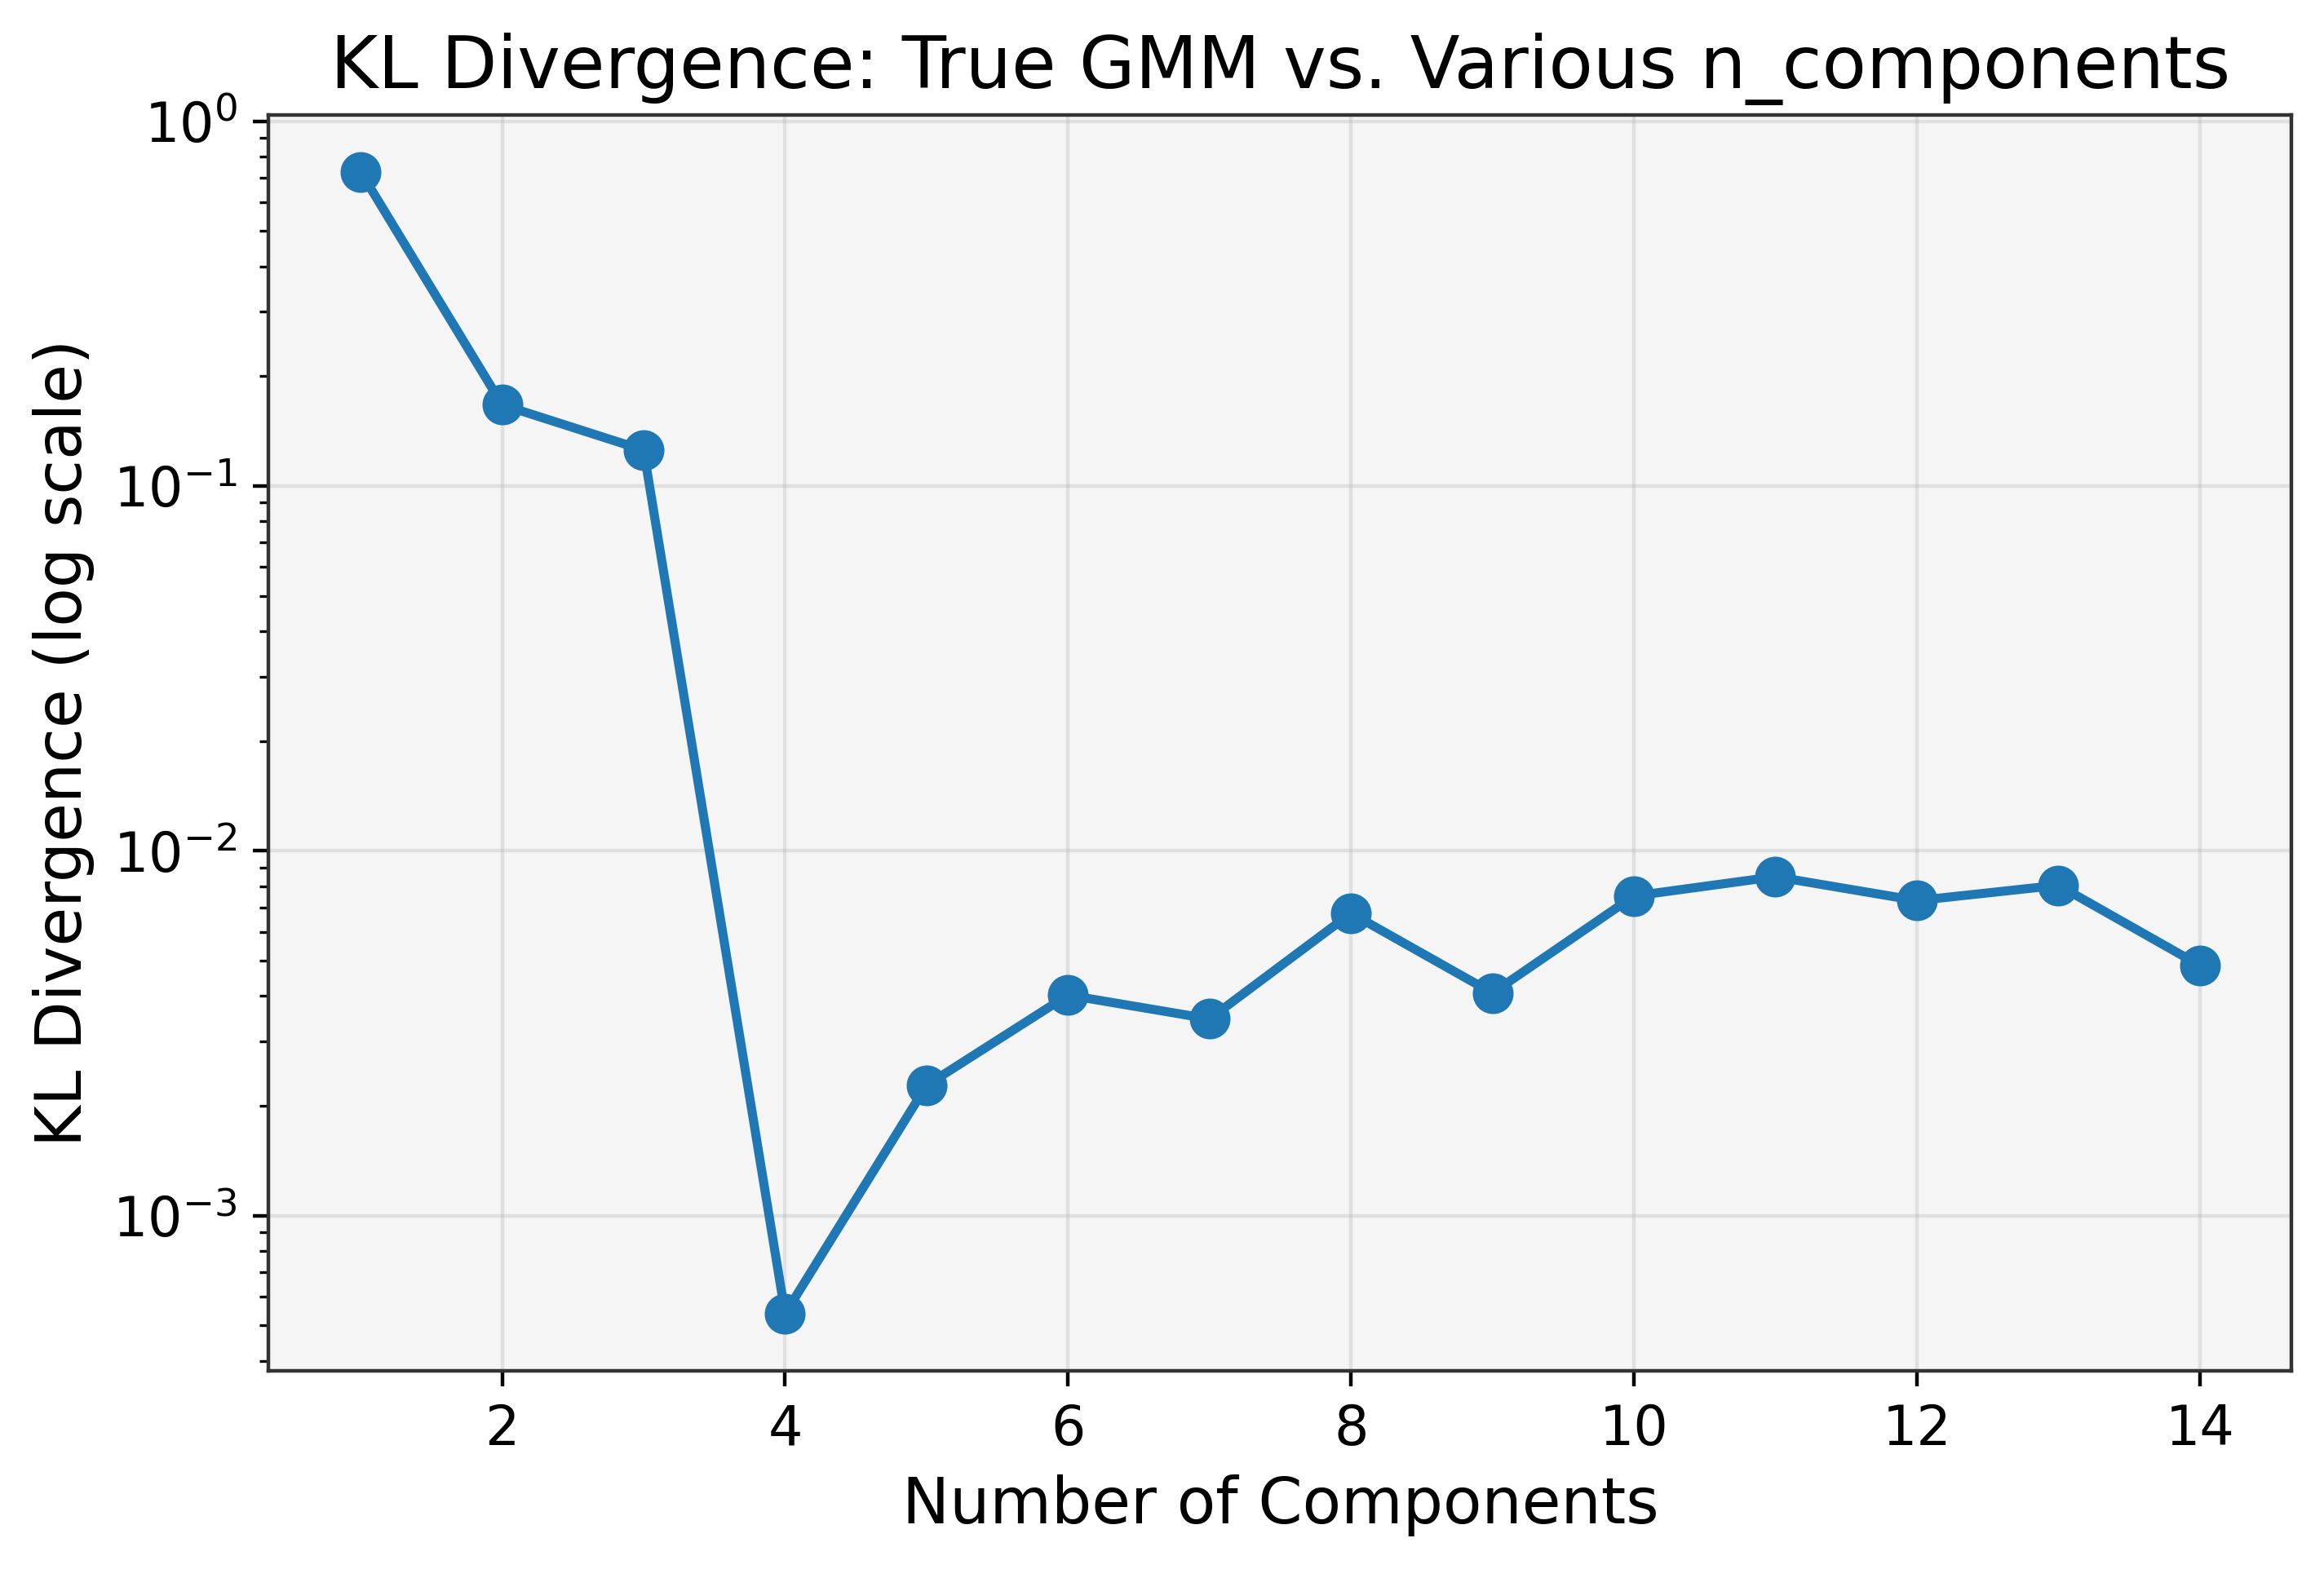

In [7]:
RUN_KL_DIVERGENCE = True
if RUN_KL_DIVERGENCE:
    print("Computing KL(p||q) for different numbers of components...")
    gmm_true = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device
    )
    gmm_true.fit(X_tensor)
    
    test_range = np.arange(1, 15)
    kl_vals = torch.zeros(len(test_range), device=device)
    for i, n in tqdm(enumerate(test_range), total=len(test_range)):
        gmm_test = GaussianMixture(
            n_features=n_features,
            n_components=n,
            covariance_type='full',
            max_iter=1000,
            init_params='kmeans',
            device=device
        )
        gmm_test.fit(X_tensor)
        
        kl_vals[i] = ClusteringMetrics.kl_divergence_gmm(gmm_true, gmm_test, n_samples=10000)

    plt.figure(figsize=(8, 5))
    plt.plot(test_range, kl_vals.cpu().numpy(), marker='o')
    plt.yscale('log')
    plt.title("KL Divergence: True GMM vs. Various n_components")
    plt.xlabel("Number of Components")
    plt.ylabel("KL Divergence (log scale)")
    plt.grid(True)
    plt.show()
